### University of Padova
#### Department of Information Engineering
#### Digital Forensics A.A. 2021/2022
#### Prof. Simone Milani

##### Students: Mohsen Kordi 2040503, Azar Bagheri Zideh Saraei 2041425

# Human Activity Recognition

## 1. Project Description

The widespreading of wearable IoT devices is greatly improving quality of life thanks to the development of 5G and data analysis techniques. However this can also lead to great security and privacy vulnerabilities when the data handling procedure is not carried out correctly. 

In this laboratory experience we will use data obtained from the Luxottica wearable glasses to perform an activity recognition task that can lead to partial tracking of the user movement.

<img src = "https://drive.google.com/uc?id=147DxZBFJ1XV1FjKIfBSGkXYMdx82R68z" align="center" height=400/>

These glasses contain a variety of sensors that can measure quantities useful to perform activity recognition and other types of tasks.
In particular we will use data from the accelerometer, gyroscope, magnetometer and pression sensor to detect signal sequences relative to a step. These will then be classified to understand if the user is walking normally, up the stairs, or down the stairs.

This problem can be divided in two smaller tasks i.e. extraction of the signal relative to a step (this can be done with standard signal processing techniques), and then classification using a neural network.

The former will be addressed with framing signal based on the number of samples, on the other hand, will be addressed with a simple CNN. 

## 2. Data gathering method

## 3. Data Preparation

### 3.1. Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
import seaborn as sns
import scipy as sp



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.metrics import confusion_matrix


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, concatenate, LeakyReLU, Softmax
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from matplotlib import interactive


from mlxtend.plotting import plot_confusion_matrix

from operator import indexOf
from statistics import mode



### 3.2. Configuration Parameters

In [2]:
DATA_PATH = 'Data'

COLUMN_LIST = ['User', 'Activity', 
'ACC X (g)', 'ACC Y (g)', 'ACC Z (g)',
'GYRO X (dps)', 'GYRO Y (dps)', 'GYRO Z (dps)',
'MAGN X (mGs)', 'MAGN Y (mGs)', 'MAGN Z (mGs)',
'ROLL (°)', 'PITCH (°)', 'YAW (°)',
'PRESSURE (Pa)']


FS = 20 # Sampling frequency
FRAME_SIZE = 100
OVERLAP = 0.1
N_FEATURES = 13

TEST_SIZE = 0.2
RANDOM_STATE = 0
N_EPOCHS = 10

ACTIVITIES = []
USERS = []

MIN_SAMPLE = 2000
OFFSET = 0.1


### 3.3. Dataset Loading

In [3]:
def read_data(data_path, columns_list, save_name=None):
    """Get data from csv files

    Args:
        data_path (string): path to the data folder
        columns_list ([string]): list of columns to read
        save_name (string, optional): Path and file name for saving comulative data. Defaults to None.

    Returns:
        Pandas.DataFrame: Dataframe of data read from all CSV files
    """
    
    # Read csv files into a dataframe
    data = pd.DataFrame()
    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            if data.empty:
                data = pd.read_csv(os.path.join(data_path, file))[columns_list]
            else:
                data = pd.concat([data, pd.read_csv(os.path.join(data_path, file))[columns_list]], ignore_index=True)
    
    # Save data to csv file        
    if save_name:
        data.to_csv(save_name+'.csv', index=False)
    
    # Return data
    return data




def plot_data(df):
    interactive(True)
    col = df.columns
    
    fig, axs = plt.subplots(ncols=1, nrows=len(col), figsize=(16,2*len(col)))
    
    colors = ['red', 'green', 'blue', 'cyan', 'orange', 'pink', 'purple', 'brown', 'grey', 'black',
              'yellow', 'magenta', 'lime', 'olive', 'teal', 'navy', 'aqua', 'maroon', 'fuchsia', 'silver']
    
    for ax in axs:
        ax.plot(df[col[axs.tolist().index(ax)]], color=colors[axs.tolist().index(ax)%len(colors)])
        ax.set_xlabel('Sample')
        ax.set_ylabel(col[axs.tolist().index(ax)])
        ax.grid('major', color='r', linestyle='--', linewidth=0.1)

    plt.show()



In [4]:
# Read data
df_all = read_data(DATA_PATH, COLUMN_LIST)


display(df_all.head(3), df_all.tail(3))

User  Activity  ACC X (g)  ACC Y (g)  ACC Z (g)  GYRO X (dps)  \
0  Azar  Standing      0.078     -1.011      0.017           0.5   
1  Azar  Standing      0.066     -1.021      0.015           0.8   
2  Azar  Standing      0.068     -1.018      0.018           1.5   

   GYRO Y (dps)  GYRO Z (dps)  MAGN X (mGs)  MAGN Y (mGs)  MAGN Z (mGs)  \
0           9.8           0.3        -179.0        -452.0        -348.0   
1           8.3           1.0        -180.5        -458.0        -343.5   
2           6.8           1.4        -176.0        -459.5        -349.5   

   ROLL (°)  PITCH (°)  YAW (°)  PRESSURE (Pa)  
0      -0.5       -3.0    154.9         100311  
1      -0.5       -3.0    155.2         100311  
2      -0.5       -3.0    155.4         100311

User  Activity  ACC X (g)  ACC Y (g)  ACC Z (g)  GYRO X (dps)  \
48997  Mohsen  Standing     -0.203     -0.992     -0.027           0.6   
48998  Mohsen  Standing     -0.203     -0.996     -0.026           0.7   
48999  Mohsen  Standing     -0.203     -0.995     -0.025           0.8   

       GYRO Y (dps)  GYRO Z (dps)  MAGN X (mGs)  MAGN Y (mGs)  MAGN Z (mGs)  \
48997          -1.5          -0.1         135.0        -774.5          28.0   
48998          -1.2           0.3         133.5        -774.5          28.0   
48999          -0.9           0.7         133.5        -776.0          22.0   

       ROLL (°)  PITCH (°)  YAW (°)  PRESSURE (Pa)  
48997       1.5       11.6    182.2         101289  
48998       1.5       11.6    182.2         101289  
48999       1.4       11.6    182.2         101289

In [5]:
# Printing data information
def show_df_info(df):
    new_line = '\n'+ 50*'-'
    print('Shape: ', df.shape, new_line)
    print(df.info())
    
    
# Printing data distribution    
def show_df_distribution(df, label):
    n_unique = df[label].nunique()
    new_line = '\n'+ 50*'-'
    print(f'Number of unique {label} is {n_unique}.', new_line)
    print('{label} distribution:\n', df[label].value_counts(), new_line)
    plt.figure(figsize=(16, 4))
    sns.barplot(x=df[label].value_counts().index, y=df[label].value_counts().values)
    plt.grid('major', color='r', linestyle='--', linewidth=0.1)
    

##### Data general info

In [6]:
# Printing data information
show_df_info(df_all)

Shape:  (49000, 15) 
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49000 entries, 0 to 48999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User           49000 non-null  object 
 1   Activity       49000 non-null  object 
 2   ACC X (g)      49000 non-null  float64
 3   ACC Y (g)      49000 non-null  float64
 4   ACC Z (g)      49000 non-null  float64
 5   GYRO X (dps)   49000 non-null  float64
 6   GYRO Y (dps)   49000 non-null  float64
 7   GYRO Z (dps)   49000 non-null  float64
 8   MAGN X (mGs)   49000 non-null  float64
 9   MAGN Y (mGs)   49000 non-null  float64
 10  MAGN Z (mGs)   49000 non-null  float64
 11  ROLL (°)       49000 non-null  float64
 12  PITCH (°)      49000 non-null  float64
 13  YAW (°)        49000 non-null  float64
 14  PRESSURE (Pa)  49000 non-null  int64  
dtypes: float64(12), int64(1), object(2)
memory usage: 5.6+ MB
None


#### Data Distribution info

Number of unique Activity is 6. 
--------------------------------------------------
{label} distribution:
 Standing         18472
Walking          11694
Elevator_Up       5997
Stairs_Up         4553
Stairs_Down       4271
Elevator_Down     4013
Name: Activity, dtype: int64 
--------------------------------------------------


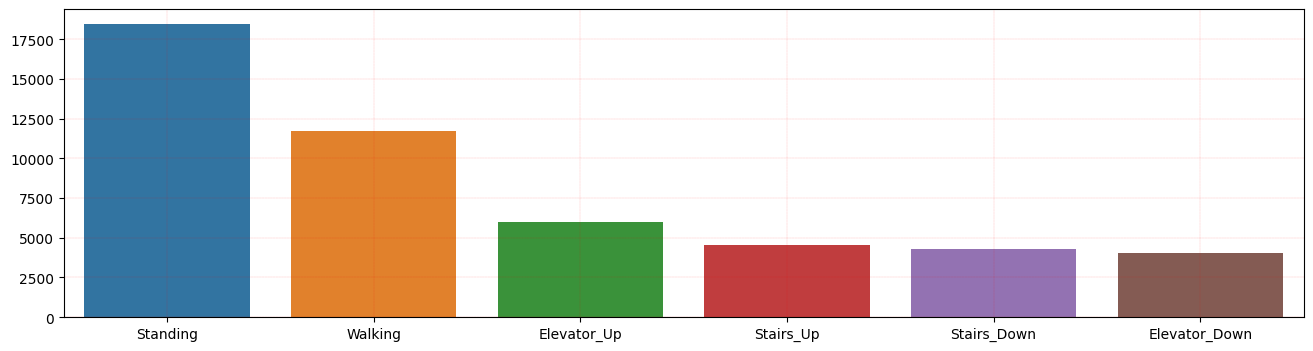

In [7]:
# Printing data distribution
show_df_distribution(df_all,'Activity')

Number of unique User is 2. 
--------------------------------------------------
{label} distribution:
 Mohsen    27000
Azar      22000
Name: User, dtype: int64 
--------------------------------------------------


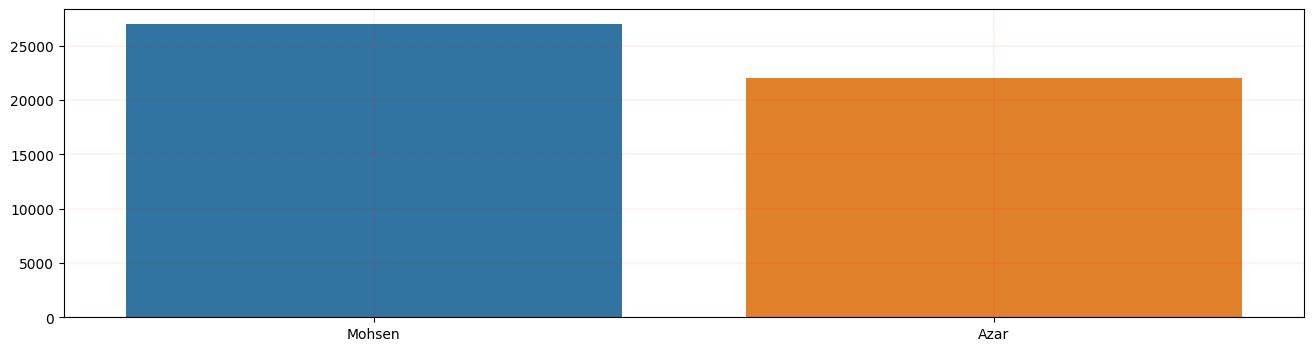

In [8]:
# Printing data distribution
show_df_distribution(df_all,'User')

In [9]:
# Finding all unique activities and users

ACTIVITIES = df_all['Activity'].value_counts().index
USERS = df_all['User'].value_counts().index   


In [10]:
# df_all.plot(subplots=True, figsize=(16, 15), grid=True)

### 3.3. Balancing number of samples per activity

In [11]:
def balance_sample(df, users, activities):
    # Balance the data by taking the same number of samples for each activity
    # Return df_balanced
    
    # activities = df['Activity'].value_counts().index
    # users = df['User'].value_counts().index

    df_balanced = pd.DataFrame()
    for u in users:
        tmp = df[df['User'] == u]
        
        balanceSample = tmp['Activity'].value_counts().min()
        offset = int(OFFSET * balanceSample)
        
        if balanceSample <= MIN_SAMPLE:
            balanceSample = MIN_SAMPLE
            offset = 0
        
        for act in activities:
            df_act = tmp[tmp['Activity'] == act].head(balanceSample + offset).copy()
            if df_balanced.empty:
            #if indexOf(activities, act) == 0:
                df_balanced = df_act[offset:]
            else:
                df_balanced = pd.concat([df_balanced, df_act[offset:]], ignore_index=True)
            
    return df_balanced


Number of unique Activity is 6. 
--------------------------------------------------
{label} distribution:
 Standing         4429
Walking          4429
Elevator_Up      4429
Stairs_Up        4311
Stairs_Down      4029
Elevator_Down    3729
Name: Activity, dtype: int64 
--------------------------------------------------


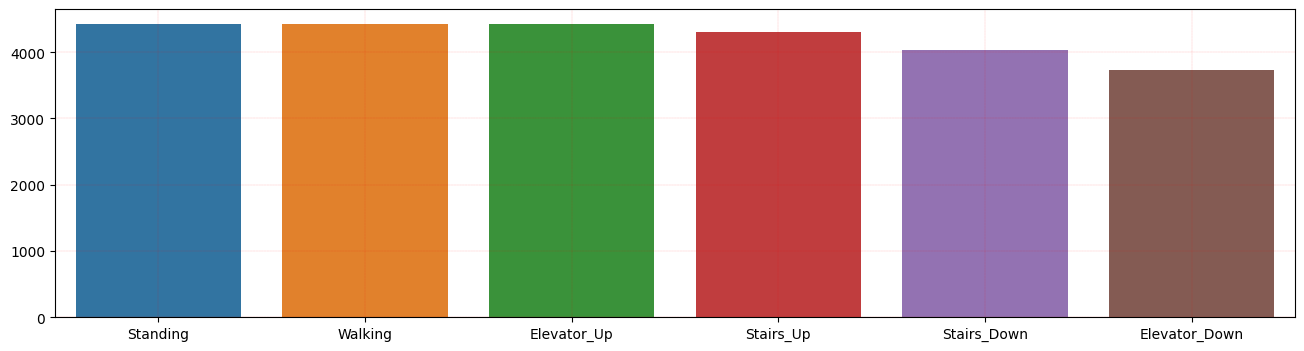

In [12]:
df_balanced = balance_sample(df_all, USERS, ACTIVITIES)

show_df_distribution(df_balanced, 'Activity')

Number of unique User is 2. 
--------------------------------------------------
{label} distribution:
 Mohsen    14321
Azar      11035
Name: User, dtype: int64 
--------------------------------------------------


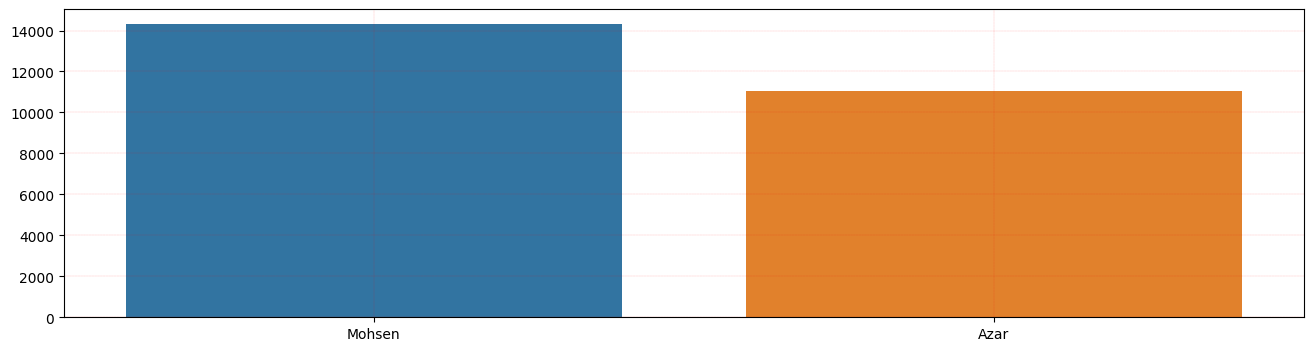

In [13]:
show_df_distribution(df_balanced, 'User')

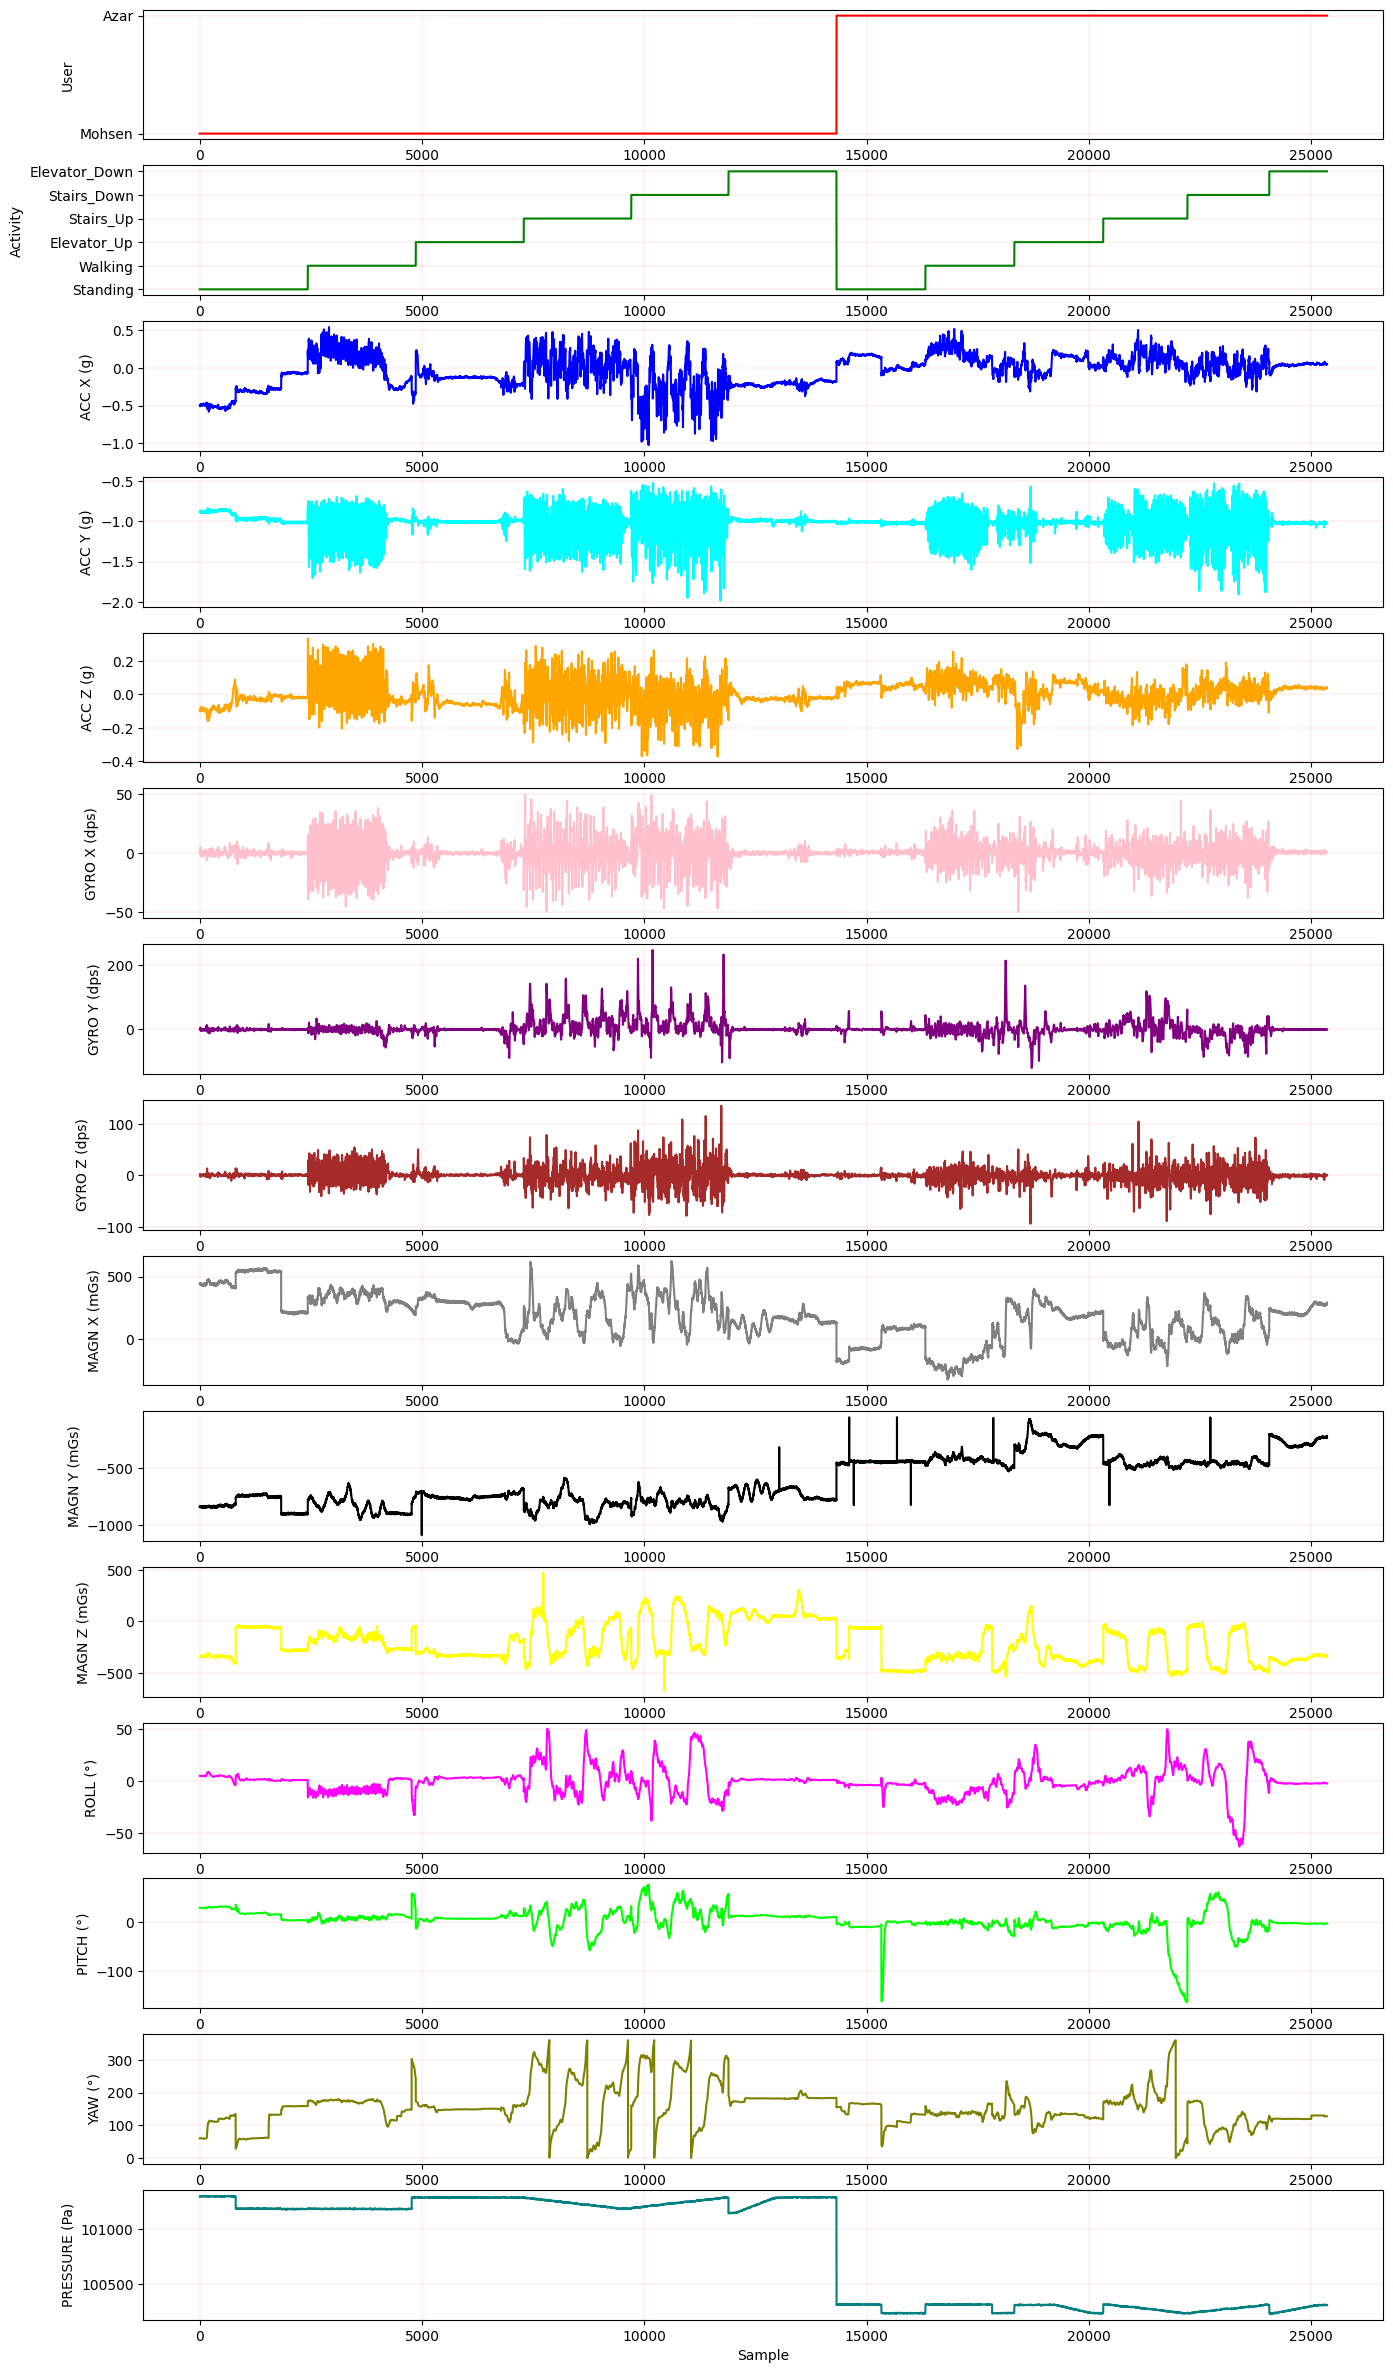

In [14]:
plot_data(df_balanced)

### 3.4. Standardized data 

Encoding activities and users to numeric data. Also, normalizing data (rescaling so that mean = 0 and std = 1).

In [15]:
def normalize_data(df, column_list, do_all=False):
    # Normalize the data using StandardScaler
    sx = pd.DataFrame(StandardScaler().fit_transform(df[df.columns[2:]]), columns=df.columns[2:])
    
    # Encode the labels               
    sx['ActLabel'] = LabelEncoder().fit_transform(df['Activity'])
    sx['UserLabel'] = LabelEncoder().fit_transform(df['User'])
    # sx['AllLabel'] = LabelEncoder().fit_transform(df['User']+'_'+df['Activity'])
    
    # a = actlabel.inverse_transform(range(sx['ActLabel'].nunique()))
    # u = userlabel.inverse_transform(range(sx['UserLabel'].nunique()))
    # t = userlabel.inverse_transform(range(sx['AllLabel'].nunique()))
    
    if do_all:
        all_label = LabelEncoder()
        sx['AllLabel'] = all_label.fit_transform(df['User']+'_'+df['Activity'])
        t = all_label.inverse_transform(range(sx['AllLabel'].nunique()))
        return sx, t
    
    else:
        return sx   #, a, u, t


In [16]:
scaled_X , ALL_LABALES = normalize_data(df_balanced, COLUMN_LIST[2:], do_all=True)
display(scaled_X.describe())

ACC X (g)     ACC Y (g)     ACC Z (g)  GYRO X (dps)  GYRO Y (dps)  \
count  2.535600e+04  2.535600e+04  2.535600e+04  2.535600e+04  2.535600e+04   
mean  -2.241813e-18 -2.062468e-16  1.793451e-17 -7.005667e-19  3.811083e-17   
std    1.000020e+00  1.000020e+00  1.000020e+00  1.000020e+00  1.000020e+00   
min   -4.665822e+00 -7.218545e+00 -4.868670e+00 -5.588813e+00 -4.980716e+00   
25%   -6.892469e-01 -2.023920e-01 -5.922849e-01 -2.509428e-01 -2.721795e-01   
50%    1.146302e-01 -4.227227e-02 -4.801777e-02 -3.036969e-02 -1.274252e-01   
75%    7.377538e-01  3.361924e-01  6.517543e-01  2.784327e-01  7.764344e-02   
max    2.773608e+00  3.451248e+00  4.267243e+00  5.450873e+00  9.896812e+00   

       GYRO Z (dps)  MAGN X (mGs)  MAGN Y (mGs)  MAGN Z (mGs)      ROLL (°)  \
count  2.535600e+04  2.535600e+04  2.535600e+04  2.535600e+04  2.535600e+04   
mean   3.642947e-18 -1.120907e-18  3.586901e-17  4.483627e-18  3.362720e-18   
std    1.000020e+00  1.000020e+00  1.000020e+00  1.000020e+00  1.000020e+00   
min   -6.454492e+00 -2.748807e+00 -2.201893e+00 -2.492393e+00 -4.804391e+00   
25%   -2.423014e-01 -6.161713e-01 -8.067368e-01 -7.393995e-01 -3.698746e-01   
50%    1.969997e-02  9.108042e-02 -4.262395e-01 -3.106487e-01  6.200877e-02   
75%    2.127536e-01  6.487212e-01  8.138997e-01  8.399230e-01  2.779504e-01   
max    9.320748e+00  2.386928e+00  2.624785e+00  3.719066e+00  3.894973e+00   

          PITCH (°)       YAW (°)  PRESSURE (Pa)      ActLabel     UserLabel  \
count  2.535600e+04  2.535600e+04   2.535600e+04  25356.000000  25356.000000   
mean   2.241813e-18 -8.967253e-18   1.061723e-14      2.574578      0.564797   
std    1.000020e+00  1.000020e+00   1.000020e+00      1.695191      0.495793   
min   -6.613143e+00 -2.589491e+00  -1.242054e+00      0.000000      0.000000   
25%   -2.722596e-01 -5.561463e-01  -1.098649e+00      1.000000      0.000000   
50%    4.419123e-02 -7.860559e-02   7.613940e-01      3.000000      1.000000   
75%    3.804202e-01  4.039974e-01   9.132343e-01      4.000000      1.000000   
max    2.915983e+00  3.483544e+00   1.012352e+00      5.000000      1.000000   

           AllLabel  
count  25356.000000  
mean       5.963362  
std        3.357388  
min        0.000000  
25%        3.000000  
50%        6.000000  
75%        9.000000  
max       11.000000

## 4. Analysis

### 4.1. Framing

In [17]:
def framing(df, label, frame_size, overlap_size, n_features):
    
    n = n_features - len(df.columns)
    # print(n)
    
    if overlap_size == 0:
        overlap_size = frame_size
    else:
        overlap_size = int(frame_size * overlap_size)

    frames = []
    labels = []
    for l in df[label].value_counts().index:
        df_label = df[df[label] == l]  

        wnd = [df_label[i: i + frame_size][df_label.columns[:n]].values for i in range(0, len(df_label) - frame_size, overlap_size)]
        wnd_label = [mode(df_label[i: i + frame_size][label].values) for i in range(0, len(df_label) - frame_size, overlap_size)]
        
        frames.extend(wnd)
        labels.extend(wnd_label)

    
    frames = np.array(frames).reshape(-1, frame_size, n_features)
    labels = np.array(labels)

    return frames, labels

In [18]:
# X_act, Y_act = get_frames(scaled_X, 'ActLabel', FRAME_SIZE, OVERLAP, N_FEATURES)
#X_user, Y_user = get_frames(scaled_X, 'UserLabel', FRAME_SIZE, OVERLAP, N_FEATURES)

# print(f'X_act shape is {X_act.shape}.')
# print(f'Y_act shape is {Y_act.shape}.')
#print(f'X_user shape is {X_user.shape}.')
#print(f'Y_user shape is {Y_user.shape}.')


### 4.2. Train and Test Dataset preparation

In [19]:
def data_split(df, label, frame_size, overlap, n_features, test_size, random_state):
    
    # Get frames
    # print(f'Frame size is {frame_size} samples. Overlap size is {overlap} samples.')
    X, Y = framing(df, label, frame_size, overlap, n_features)
    
    # Split data
    # print(f'Test size is {test_size}.')
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    # Reshape data
    # print(f'Reshaping train set..')
    X_train = X_train.reshape(X_train.shape[0], frame_size, n_features, 1)
    
    # print(f'Reshaping test set..')
    X_test = X_test.reshape(X_test.shape[0], frame_size, n_features, 1)
    
    # Return data
    # print(f'Returning data..')
    return X_train, X_test, Y_train, Y_test

Splitting data to train and test sets based on activity label.

In [20]:
X_train_user, X_test_user, Y_train_user, Y_test_user = data_split(scaled_X, 'UserLabel', FRAME_SIZE*4, OVERLAP, N_FEATURES, TEST_SIZE, RANDOM_STATE)
X_train_act, X_test_act, Y_train_act, Y_test_act = data_split(scaled_X, 'ActLabel', FRAME_SIZE, OVERLAP, N_FEATURES, TEST_SIZE, RANDOM_STATE)


# print(f'X_train_user shape is {X_train_user.shape}.')
# print(f'X_test_user shape is {X_test_user.shape}.')
# print(f'Y_train_user shape is {Y_train_user.shape}.')
# print(f'Y_test_user shape is {Y_test_user.shape}.')

# print(f'X_train_act shape is {X_train_act.shape}.')
# print(f'X_test_act shape is {X_test_act.shape}.')
# print(f'Y_train_act shape is {Y_train_act.shape}.')
# print(f'Y_test_act shape is {Y_test_act.shape}.')


-3
-3


### 4.3. CNN Model

#### Activity Recognition CNN Model

In [21]:
model_act = Sequential()
model_act.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=X_train_act[0].shape))
# model_act.add(Dropout(0.1))

model_act.add(Conv2D(16, kernel_size=(2, 2), activation='relu'))
# model_act.add(Dropout(0.5))

model_act.add(Conv2D(8, kernel_size=(2, 2), activation='relu'))
model_act.add(Dropout(0.5))

model_act.add(Flatten())
model_act.add(Dense(16, activation='relu'))
model_act.add(Dropout(0.5))
model_act.add(Dense(len(ACTIVITIES), activation='softmax'))

callbacks_act = [
    ModelCheckpoint("act_model.h5", save_best_only=True),
    TensorBoard("act_logs")
]
model_act.compile(optimizer=Adam(learning_rate = 0.001), loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])


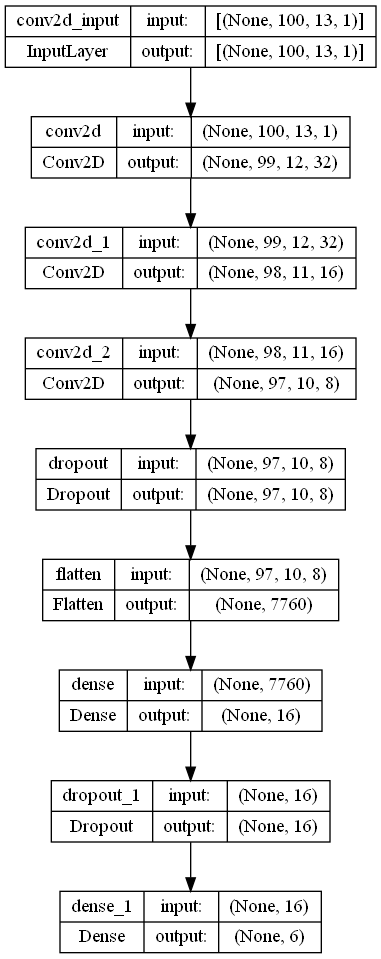

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 12, 32)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 11, 16)        2064      
                                                                 
 conv2d_2 (Conv2D)           (None, 97, 10, 8)         520       
                                                                 
 dropout (Dropout)           (None, 97, 10, 8)         0         
                                                                 
 flatten (Flatten)           (None, 7760)              0         
                                                                 
 dense (Dense)               (None, 16)                124176    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

None

In [22]:
# tf.keras.utils.plot_model(model_act, "model_act.png", show_shapes=True)
display(tf.keras.utils.plot_model(model_act, "model_act.png", show_shapes=True))
display(model_act.summary())

#### Fitting model on data

In [23]:
history_act = model_act.fit(X_train_act, Y_train_act, epochs = N_EPOCHS, validation_data= (X_test_act, Y_test_act), verbose=1, callbacks=callbacks_act)
model_act.save_weights("act_model.h5")

Epoch 1/10
62/62 [==============================] - 8s 90ms/step - loss: 1.3937 - accuracy: 0.4210 - val_loss: 0.9096 - val_accuracy: 0.6774
Epoch 2/10
62/62 [==============================] - 5s 78ms/step - loss: 0.9951 - accuracy: 0.5916 - val_loss: 0.5966 - val_accuracy: 0.9113
Epoch 3/10
62/62 [==============================] - 5s 85ms/step - loss: 0.8457 - accuracy: 0.6562 - val_loss: 0.4048 - val_accuracy: 0.9012
Epoch 4/10
62/62 [==============================] - 8s 129ms/step - loss: 0.7414 - accuracy: 0.7113 - val_loss: 0.3105 - val_accuracy: 0.9577
Epoch 5/10
62/62 [==============================] - 5s 89ms/step - loss: 0.6721 - accuracy: 0.7330 - val_loss: 0.2373 - val_accuracy: 0.9556
Epoch 6/10
62/62 [==============================] - 5s 75ms/step - loss: 0.6602 - accuracy: 0.7426 - val_loss: 0.2376 - val_accuracy: 0.9738
Epoch 7/10
62/62 [==============================] - 4s 58ms/step - loss: 0.6265 - accuracy: 0.7486 - val_loss: 0.2230 - val_accuracy: 0.9657
Epoch 8/10
6

In [24]:
def model_result(model, X_test, Y_test, classes, history):
    
    def plot_confusion(model, x_test, y_test, classes):
        y_pred = model.predict(x_test).argmax(axis=1)
        cm = confusion_matrix(y_test, y_pred, normalize="pred")
        ax = sns.heatmap(cm, annot=True,  fmt=".2f", linewidths=.5)
        ax.set_xlabel("Predicted Labels")
        ax.set_ylabel("True Labels")
        ax.set_title("Confusion Matrix")
        tick_marks = np.arange(len(classes))
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes, rotation=45)
        ax.xaxis.set_ticklabels(classes, rotation=45)
        ax.yaxis.set_ticklabels(classes, rotation=45)

        return ax


    fig, axs = plt.subplots(1 , 2, figsize = (16, 6))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
    axs[0].grid()
    axs[0].set_title('Model Accuracy and Loss')

    axs[1] = plot_confusion(model, X_test, Y_test, classes)
    # axs[1] = plot_confusion(model_act, X_test_act, Y_test_act, ACTIVITIES.tolist())

    plt.show()

16/16 [==============================] - 0s 13ms/step


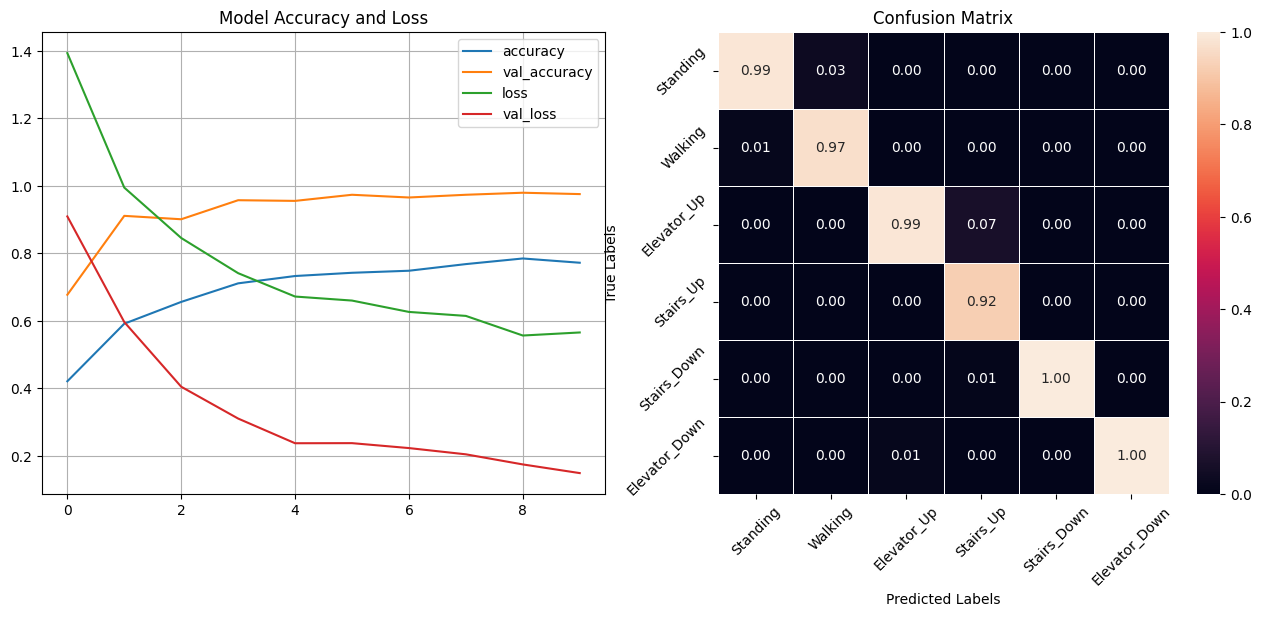

In [25]:
model_result(model_act, X_test_act, Y_test_act, ACTIVITIES.tolist(), history_act)

#### User Identification

In [26]:
model_user = Sequential()
model_user.add(Conv2D(8, kernel_size=(2, 2), activation='relu', input_shape=X_train_user[0].shape))
# model_user.add(Dropout(0.1))

model_user.add(Conv2D(4, kernel_size=(2, 2), activation='relu'))
# model_user.add(Dropout(0.5))

model_user.add(Flatten())
model_user.add(Dense(4, activation='relu'))
model_user.add(Dropout(0.7))
model_user.add(Dense(len(USERS), activation='softmax'))

callbacks_user = [
    ModelCheckpoint("user_model.h5", save_best_only=True),
    TensorBoard("user_logs")
]
model_user.compile(optimizer=Adam(learning_rate = 0.001), loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

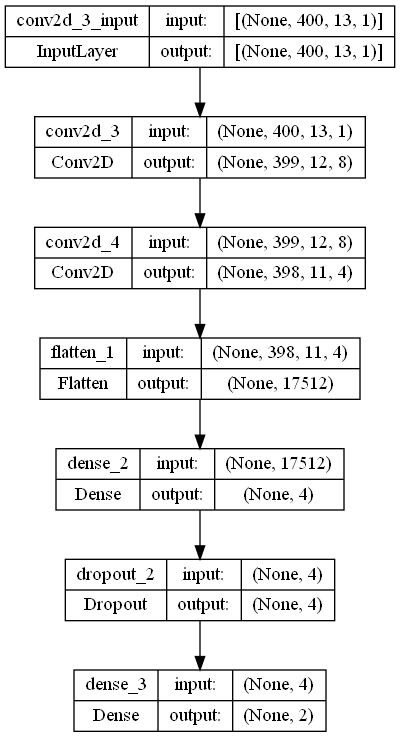

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 399, 12, 8)        40        
                                                                 
 conv2d_4 (Conv2D)           (None, 398, 11, 4)        132       
                                                                 
 flatten_1 (Flatten)         (None, 17512)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 70052     
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
Total params: 70,234
Trainable params: 70,234
Non-trai

None

In [27]:
# tf.keras.utils.plot_model(model_user, "model_user.png", show_shapes=True)
display(tf.keras.utils.plot_model(model_user, "model_user.png", show_shapes=True))
display(model_user.summary())

In [28]:
history_user = model_user.fit(X_train_user, Y_train_user, epochs = N_EPOCHS, validation_data= (X_test_user, Y_test_user), verbose=1, callbacks=callbacks_user)
model_user.save_weights("user_model.h5")

Epoch 1/10
16/16 [==============================] - 2s 83ms/step - loss: 0.5669 - accuracy: 0.6789 - val_loss: 0.3142 - val_accuracy: 0.9350
Epoch 2/10
16/16 [==============================] - 1s 73ms/step - loss: 0.4282 - accuracy: 0.8171 - val_loss: 0.2947 - val_accuracy: 0.9919
Epoch 3/10
16/16 [==============================] - 1s 62ms/step - loss: 0.4346 - accuracy: 0.7988 - val_loss: 0.2859 - val_accuracy: 1.0000
Epoch 4/10
16/16 [==============================] - 1s 60ms/step - loss: 0.4195 - accuracy: 0.8150 - val_loss: 0.2815 - val_accuracy: 0.9756
Epoch 5/10
16/16 [==============================] - 1s 58ms/step - loss: 0.4311 - accuracy: 0.7927 - val_loss: 0.2749 - val_accuracy: 1.0000
Epoch 6/10
16/16 [==============================] - 1s 59ms/step - loss: 0.4018 - accuracy: 0.8313 - val_loss: 0.2698 - val_accuracy: 0.9919
Epoch 7/10
16/16 [==============================] - 1s 58ms/step - loss: 0.4394 - accuracy: 0.7785 - val_loss: 0.2648 - val_accuracy: 0.9919
Epoch 8/10
16

4/4 [==============================] - 0s 19ms/step


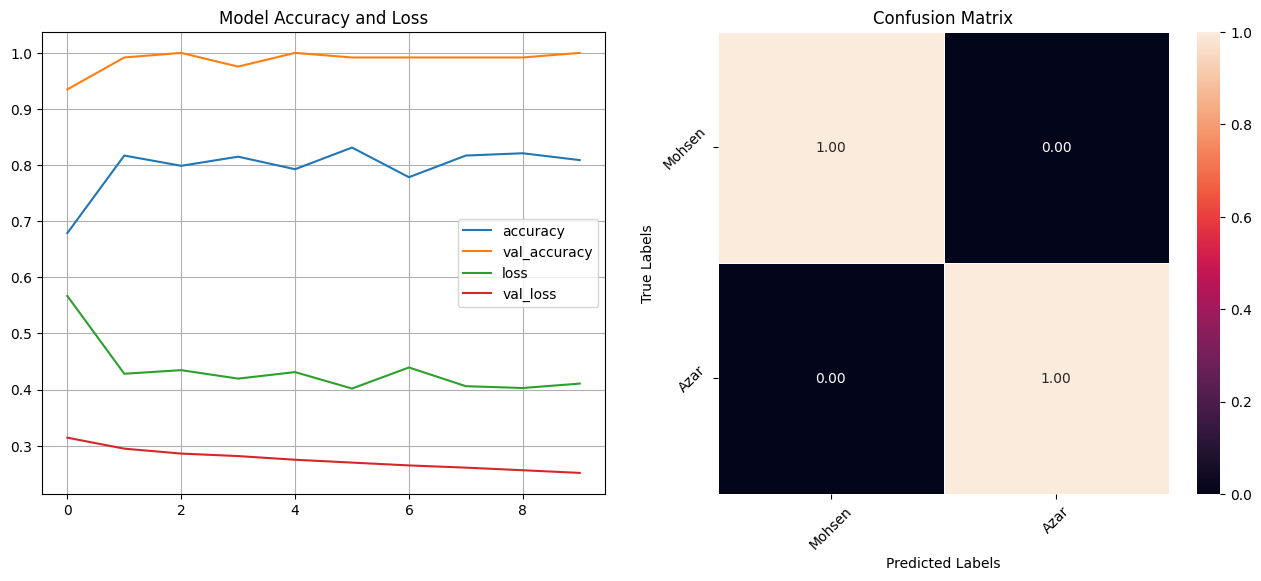

In [29]:
model_result(model_user, X_test_user, Y_test_user, USERS.tolist(), history_user)

# All

-3


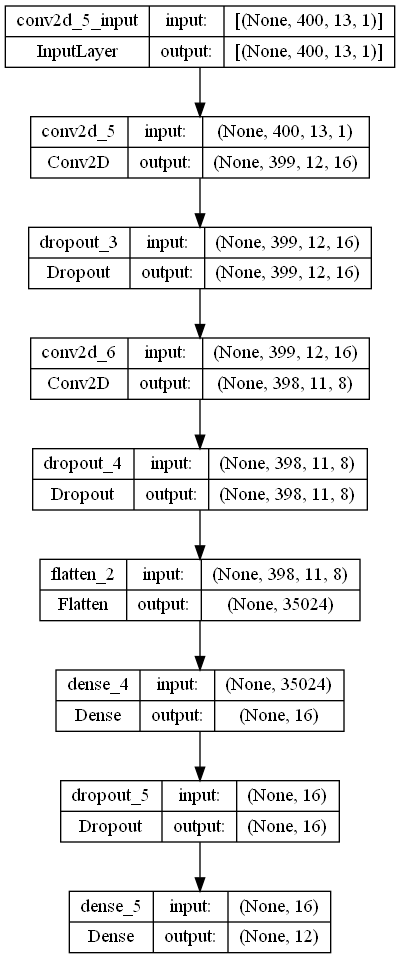

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 399, 12, 16)       80        
                                                                 
 dropout_3 (Dropout)         (None, 399, 12, 16)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 398, 11, 8)        520       
                                                                 
 dropout_4 (Dropout)         (None, 398, 11, 8)        0         
                                                                 
 flatten_2 (Flatten)         (None, 35024)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                560400    
                                                                 
 dropout_5 (Dropout)         (None, 16)               

None

Epoch 1/10
13/13 [==============================] - 5s 200ms/step - loss: 2.4309 - accuracy: 0.1232 - val_loss: 2.0147 - val_accuracy: 0.2308
Epoch 2/10
13/13 [==============================] - 3s 207ms/step - loss: 2.1742 - accuracy: 0.1787 - val_loss: 1.8883 - val_accuracy: 0.2692
Epoch 3/10
13/13 [==============================] - 2s 165ms/step - loss: 2.0723 - accuracy: 0.1957 - val_loss: 1.7748 - val_accuracy: 0.2596
Epoch 4/10
13/13 [==============================] - 2s 170ms/step - loss: 1.9856 - accuracy: 0.2126 - val_loss: 1.7068 - val_accuracy: 0.2500
Epoch 5/10
13/13 [==============================] - 2s 166ms/step - loss: 1.9930 - accuracy: 0.1908 - val_loss: 1.6409 - val_accuracy: 0.3077
Epoch 6/10
13/13 [==============================] - 2s 172ms/step - loss: 1.9314 - accuracy: 0.2101 - val_loss: 1.5855 - val_accuracy: 0.3462
Epoch 7/10
13/13 [==============================] - 2s 164ms/step - loss: 1.8927 - accuracy: 0.2077 - val_loss: 1.5589 - val_accuracy: 0.3077
Epoch 

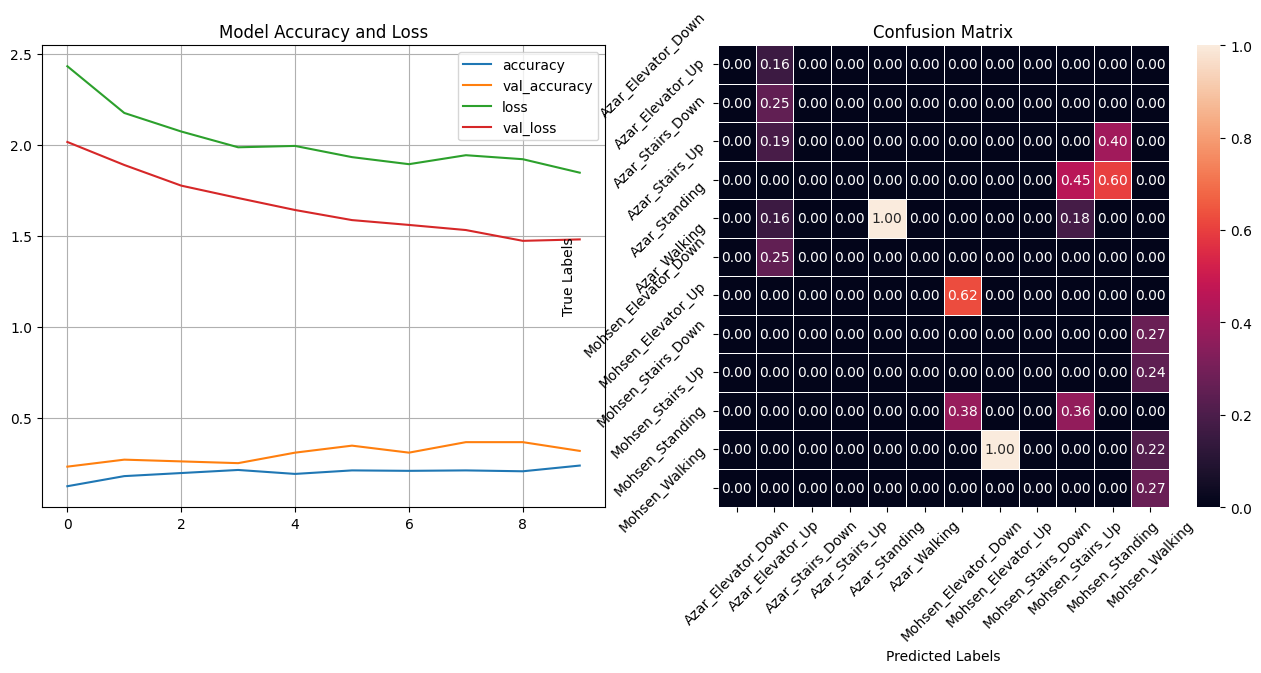

In [30]:
X_train_all, X_test_all, Y_train_all, Y_test_all = data_split(scaled_X, 'AllLabel', FRAME_SIZE*4, OVERLAP, N_FEATURES, TEST_SIZE, RANDOM_STATE)

model_all = Sequential()
model_all.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=X_train_all[0].shape))
model_all.add(Dropout(0.1))

model_all.add(Conv2D(8, kernel_size=(2, 2), activation='relu'))
model_all.add(Dropout(0.2))

model_all.add(Flatten())
model_all.add(Dense(16, activation='relu'))
model_all.add(Dropout(0.5))
model_all.add(Dense(len(ALL_LABALES), activation='softmax'))

callbacks_all = [
    ModelCheckpoint("all_model.h5", save_best_only=True),
    TensorBoard("all_logs")
]
model_all.compile(optimizer=Adam(learning_rate = 0.001), loss = tf.keras.losses.sparse_categorical_crossentropy, metrics = ['accuracy'])

# tf.keras.utils.plot_model(model_all, "model_all.png", show_shapes=True)
display(tf.keras.utils.plot_model(model_all, "model_all.png", show_shapes=True))
display(model_all.summary())

history_all = model_all.fit(X_train_all, Y_train_all, epochs = N_EPOCHS, validation_data= (X_test_all, Y_test_all), verbose=1, callbacks=callbacks_all)
model_all.save_weights("all_model.h5")

model_result(model_all, X_test_all, Y_test_all, ALL_LABALES.tolist(), history_all)